## Step 1: import the necessary packages

In [1]:
import sys
assert sys.version_info >= (3, 5)

import tensorflow as tf
assert tf.__version__ >= "2.0"
import sklearn
import keras

%load_ext tensorboard

#import other common packages
import os
import numpy as np

#specify fig printing
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

#specify location for saving figures
project_root_dir = "."
project_id = "sun397"
images_path = os.path.join(project_root_dir, "images", project_id)
os.makedirs(images_path, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join(images_path, fig_id + "." + fig_extension)
  print("saving figure", fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

#set random seed
np.random.seed(42)
tf.random.set_seed(42)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Step 2: Download the CIFAR100 dataset

In [2]:
from tensorflow.keras.datasets import cifar100
(X_train_full, y_train_full), (X_test, y_test) = cifar100.load_data()

### 2.1 divide the training set into training and validation sets

In [3]:
X_train, X_val = X_train_full[5000:], X_train_full[:5000]
y_train, y_val = y_train_full[5000:], y_train_full[:5000]

train_set_size = X_train.shape[0]
valid_set_size = X_val.shape[0]

#validate the shape of the datasets
print(f'X_train shape : {X_train.shape}')
print(f'y_train shape : {y_train.shape}')
print(f'X_val shape : {X_val.shape}')
print(f'y_val shape : {y_val.shape}')
print(f'train_set_size : {train_set_size}')
print(f'valid_set_size : {valid_set_size}')

X_train shape : (45000, 32, 32, 3)
y_train shape : (45000, 1)
X_val shape : (5000, 32, 32, 3)
y_val shape : (5000, 1)
train_set_size : 45000
valid_set_size : 5000


## Step 3: Create tensorflow pipeline

### 3.1 Convert data into tensor slices

In [4]:
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train))
val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

### 3.2 Create functions for loading data through the tf.data api

In [5]:
#import necessary modules
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

def create_example(image, label): #saves dataset to a set of TFRecord files
  image_data = tf.io.serialize_tensor(image)
  return Example(
      features=Features(
          feature={
          "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
          "label": Feature(int64_list=Int64List(value=label))
      }
      )
  )

In [6]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards=10):
  paths = ["{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards) for index in range(n_shards)]
  with ExitStack() as stack:
    writers = [stack.enter_context(tf.io.TFRecordWriter(path)) for path in paths]
    for index, (image, label) in dataset.enumerate():
      shard = index % n_shards
      example = create_example(image, label)
      writers[shard].write(example.SerializeToString())
  return paths

In [7]:
train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", val_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)

### 3.3 Create function for performing preprocessing on the fly

In [8]:
def preprocess(tfrecord):
  feature_descriptions = {
      "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
      "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
  }
  example = tf.io.parse_single_example(tfrecord, feature_descriptions)
  image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
  image = tf.reshape(image, shape=[32, 32, 3])
  image = tf.image.resize(image, [299, 299])
  image = tf.keras.applications.xception.preprocess_input(image)
  return image, example["label"]

def cifar_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None, n_parse_threads=5, batch_size=32, cache=True):
  dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
  if cache:
    dataset = dataset.cache()
  if shuffle_buffer_size:
    dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
  dataset = dataset.batch(batch_size)
  return dataset.prefetch(1)

In [9]:
train_set = cifar_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = cifar_dataset(valid_filepaths)
test_set = cifar_dataset(test_filepaths)

### 3.4 Visualize data

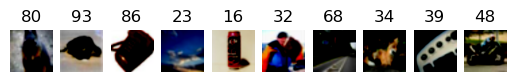

In [44]:
#visualize a sample of the images
for X, y in train_set.take(1):
  for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X[i], cmap="binary")
    plt.axis("off")
    plt.title(str(y[i].numpy()))

## Step 4: Model Development

### 4.1 Load Exception model and prep

In [11]:
base_model = keras.applications.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(100, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

In [12]:
for index, layer in enumerate(base_model.layers):
  print (index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

### 4.2 Set layers trainability to false, compile, and fit

In [13]:
#set the model layers to trainable.false
for layer in base_model.layers:
  layer.trainable=False

In [14]:
#compile the model
batch_size = 32
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])
history = model.fit(train_set, validation_data = valid_set, epochs=10)

Epoch 1/10
1407/1407 [==============================] - 371s 258ms/step - loss: 1.4628 - accuracy: 0.6060 - val_loss: 1.2081 - val_accuracy: 0.6574
Epoch 2/10
1407/1407 [==============================] - 365s 260ms/step - loss: 1.0110 - accuracy: 0.7113 - val_loss: 1.1717 - val_accuracy: 0.6686
Epoch 3/10
1407/1407 [==============================] - 360s 255ms/step - loss: 0.9500 - accuracy: 0.7308 - val_loss: 1.1548 - val_accuracy: 0.6672
Epoch 4/10
1407/1407 [==============================] - 360s 256ms/step - loss: 0.9204 - accuracy: 0.7400 - val_loss: 1.1476 - val_accuracy: 0.6714
Epoch 5/10
1407/1407 [==============================] - 359s 255ms/step - loss: 0.9011 - accuracy: 0.7471 - val_loss: 1.1394 - val_accuracy: 0.6730
Epoch 6/10
1407/1407 [==============================] - 365s 260ms/step - loss: 0.8871 - accuracy: 0.7500 - val_loss: 1.1371 - val_accuracy: 0.6726
Epoch 7/10
1407/1407 [==============================] - 365s 259ms/step - loss: 0.8763 - accuracy: 0.7536 - val_

### 4.3 Create 1CycleScheduling class for optimizing learning rate

In [15]:
K = keras.backend

class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)
     


### 4.4 Add callbacks

In [16]:
#create callbacks
import math

n_epochs = 30
batch_size=32
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=4)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_1cycle_model.h5", save_best_only=True)
run_index = 1 #increment every time you run the model
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
onecycle_callbacks = [onecycle, early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [17]:
#load tensorboard

%tensorboard --logdir=./my_mnist_logs --port=6006

### 4.5 Set layer trainability back to true, compile, and fit

In [18]:
#set the model layers to trainable.true
for layer in base_model.layers:
  layer.trainable=True

In [20]:
#compile the model
batch_size = 32
optimizer = keras.optimizers.SGD()
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])
history = model.fit(train_set, validation_data = valid_set, epochs=20, callbacks=[onecycle_callbacks])

Epoch 1/20
1407/1407 [==============================] - 1236s 875ms/step - loss: 0.6272 - accuracy: 0.8115 - val_loss: 0.7024 - val_accuracy: 0.7842
Epoch 2/20
1407/1407 [==============================] - 1228s 873ms/step - loss: 0.4342 - accuracy: 0.8671 - val_loss: 0.6608 - val_accuracy: 0.7962
Epoch 3/20
1407/1407 [==============================] - 1231s 875ms/step - loss: 0.2901 - accuracy: 0.9136 - val_loss: 0.6278 - val_accuracy: 0.8118
Epoch 4/20
1407/1407 [==============================] - 1229s 874ms/step - loss: 0.1827 - accuracy: 0.9503 - val_loss: 0.6246 - val_accuracy: 0.8196
Epoch 5/20
1407/1407 [==============================] - 1223s 869ms/step - loss: 0.1087 - accuracy: 0.9752 - val_loss: 0.6355 - val_accuracy: 0.8172
Epoch 6/20
1407/1407 [==============================] - 1222s 868ms/step - loss: 0.0676 - accuracy: 0.9874 - val_loss: 0.6710 - val_accuracy: 0.8194
Epoch 7/20
1407/1407 [==============================] - 1228s 872ms/step - loss: 0.0416 - accuracy: 0.9941

### 4.6 Evaluate model on test set

In [22]:
best_model = keras.models.load_model("my_1cycle_model.h5")
best_model.evaluate(test_set)

313/313 [==============================] - 76s 239ms/step - loss: 0.6233 - accuracy: 0.8235


[0.6233493685722351, 0.8234999775886536]

### 4.7 Load a few images from test_set and predict their labels using the saved model

1/1 [==============================] - 0s 60ms/step


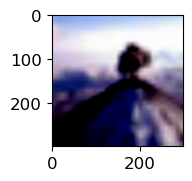

Top-5 predictions:
 1. 68 59.344%
 2. 49 26.115%
 3. 76 11.136%
 4. 90 0.883%
 5. 32 0.585%
answer: 49


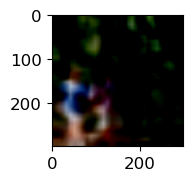

Top-5 predictions:
 1. 80 99.882%
 2. 64 0.060%
 3. 65 0.054%
 4. 50 0.003%
 5. 88 0.001%
answer: 33


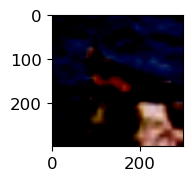

Top-5 predictions:
 1. 72 97.052%
 2. 55 2.914%
 3. 4 0.023%
 4. 71 0.004%
 5. 93 0.002%
answer: 72


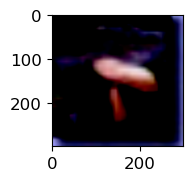

Top-5 predictions:
 1. 51 100.000%
 2. 91 0.000%
 3. 77 0.000%
 4. 26 0.000%
 5. 4 0.000%
answer: 51


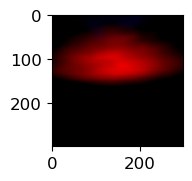

Top-5 predictions:
 1. 71 55.269%
 2. 23 42.063%
 3. 60 2.606%
 4. 33 0.038%
 5. 49 0.012%
answer: 71


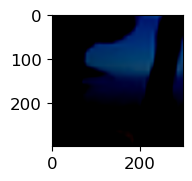

Top-5 predictions:
 1. 71 97.864%
 2. 33 1.058%
 3. 40 0.339%
 4. 59 0.250%
 5. 56 0.197%
answer: 71


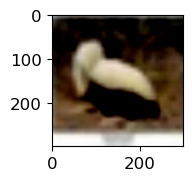

Top-5 predictions:
 1. 75 99.965%
 2. 44 0.008%
 3. 64 0.005%
 4. 27 0.004%
 5. 7 0.002%
answer: 75


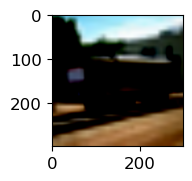

Top-5 predictions:
 1. 81 93.810%
 2. 90 6.054%
 3. 13 0.059%
 4. 33 0.007%
 5. 25 0.005%
answer: 81


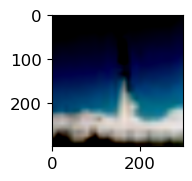

Top-5 predictions:
 1. 69 99.925%
 2. 9 0.014%
 3. 76 0.012%
 4. 85 0.006%
 5. 40 0.005%
answer: 69


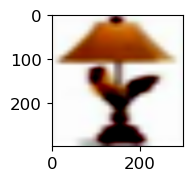

Top-5 predictions:
 1. 40 99.239%
 2. 84 0.466%
 3. 28 0.100%
 4. 86 0.030%
 5. 76 0.009%
answer: 40


In [37]:
for images, labels in test_set.take(1):
    test_images = images
    test_labels = labels

n_new = 10
Y_probas = model.predict(images)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(20, 23))
    plt.subplot(1, n_new, index+1)
    plt.imshow(test_images[index], cmap="binary")
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_label = top_k.indices[index, k]
        proba = 100 * top_k.values[index, k]
        print(" {}. {} {:.3f}%".format(k + 1, class_label, proba))
    print("answer: {}".format(labels[index].numpy()))